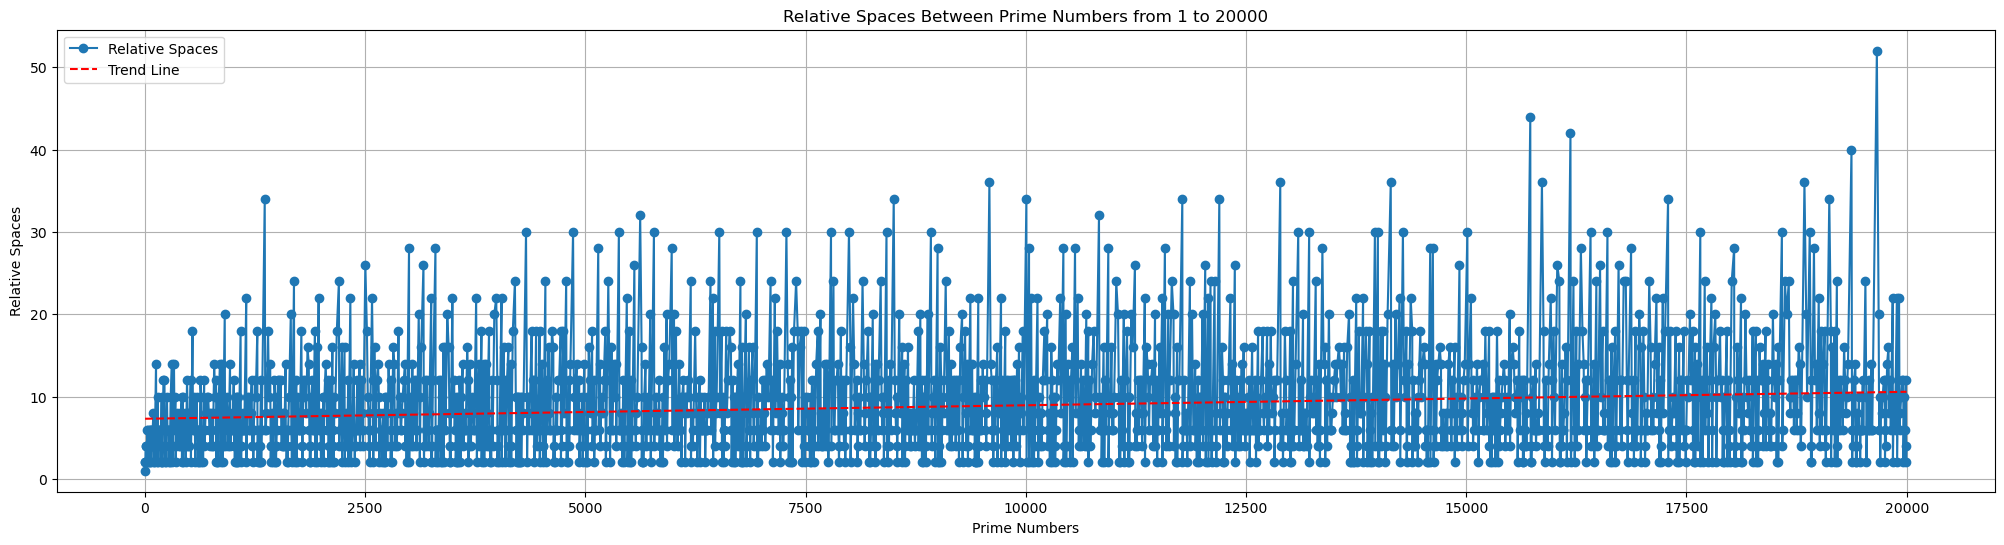

In [8]:
import numpy as np

import matplotlib.pyplot as plt

# Function to check if a number is prime
def is_prime(num):
    if num < 2:
        return False
    for i in range(2, int(num**0.5) + 1):
        if num % i == 0:
            return False
    return True

# Generate prime numbers from 1 to 20000
primes = [num for num in range(1, 20001) if is_prime(num)]

# Calculate the relative spaces between primes
spaces = [primes[i] - primes[i-1] for i in range(1, len(primes))]

# Calculate the trend line
z = np.polyfit(primes[1:], spaces, 1)
p = np.poly1d(z)

# Plot the graph
plt.figure(figsize=(25, 6))
plt.plot(primes[1:], spaces, marker='o', label='Relative Spaces')
plt.plot(primes[1:], p(primes[1:]), "r--", label='Trend Line')
plt.title('Relative Spaces Between Prime Numbers from 1 to 20000')
plt.xlabel('Prime Numbers')
plt.ylabel('Relative Spaces')
plt.grid(True)
plt.legend()
plt.show()